# Clustering Text Documents Using K-Means

We use publicly available dataset consists of 20 news groups(categories). In order to perform k-means, we need to convert text into numbers, which is done with the help TF-IDF. TF-IDF determines the importance of the words based on its frequency. These features are fed to K-means algorithm to do clustering. In order to perform pre-processing, we use NLTK library for tokenization and lemmatization/stemming

In [1]:
from __future__ import division
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn import metrics
import string
from string import punctuation
import pandas as pd
import numpy as np
import re

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import itertools
%matplotlib inline

### TfidfVectorizer

Convert a collection of raw documents to a matrix of TF-IDF features.

Equivalent to CountVectorizer followed by TfidfTransformer.

# Steps 

## Stages: 

i. Pre-processing of the dataset

ii. Creation of Term Document Matrix

iii. TF-IDF (Term Frequency – Inverse Document Frequency) Normalization

iv. K-Means Clustering using Euclidean Distances (sklearn by default uses Euclidean distances)

v. Auto-Tagging based on Cluster Centers

### Stage 1: (Pre-processing)

i. Removing punctuations

ii. Transforming to lower case

iii. Grammatically tagging sentences and removing pre-identified stop phrases (Chunking)

iv. Removing numbers from the document

v. Stripping any excess white spaces


vi. Removing generic words of the English language viz. determiners, articles, conjunctions and other parts of speech.

vii. Document Stemming which reduces each word to its root using Porter’s stemming algorithm.




In [2]:
training_set = fetch_20newsgroups(subset='train', shuffle=True)
target = training_set.target
print len(training_set.data)


11314


In [3]:
df = pd.DataFrame(training_set.data, columns=["data"])
df["targets"] = target
df.head(10)


,data,targets
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14
5,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,16
6,From: bmdelane@quads.uchicago.edu (brian manni...,13
7,From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...,3
8,From: holmes7000@iscsvax.uni.edu\nSubject: WIn...,2
9,From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...,4


# Determine distribution of classes

In [4]:
df.groupby('targets').count()

,data
targets,
0,480
1,584
2,591
3,590
4,578
5,593
6,585
7,594
8,598


In [5]:
# print one sample of data
print df["data"][0]

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







## Text Normalization 

Since dataset contains many non-relevant words therefore we do pre-processing so that our algorithm can classify the data efficiently. 

### Pre-processing steps:

i. Lemmatization / Stemming

ii. Sentence Tokenization 

iii. Word Tokenization 

iv. Remove punctuations and contractions

v. Apply Regex expressions to remove unwanted words(such as numbers i.e. A45 )

In [6]:
class text_normalization:
    
    def __init__(self):
        self.punctuations = list(punctuation)
        self.stemmer = PorterStemmer()
        self.lemma = WordNetLemmatizer()
        self.contractions = {"'nt":"not", "'ll": " will","'d":"would" ,"'re":"are", "'ve":"have", "'m":"am", "'s":"is"}
        
    '''
    This function takes text as input 
    and returns list of tokenized words(punctuations not included) 
    '''    
    def word_tokenizer(self,text):

        self.word_tokenize_list = []
        
        for word in word_tokenize(text):
            result = 0
            #find words containing numbers i.e A45, or 45 
            result = re.findall(r'([a-z]|[A-Z])(\d)|(\d)', word)

            findUrl = re.findall(r'([a-z])(\.com)', word)
            
            findBlankWords = re.findall(r'(([a-z])(__))|(__)([a-z])', word)
            
            findBlanks = re.findall(r'(__)', word)
            
            if word in self.contractions:

                self.word_tokenize_list.append(self.contractions[word])
            
            elif len(findBlankWords) > 0 or len(findBlanks) > 0:
                continue
                
            elif len(result) > 0:
                continue
                
            elif len(findUrl) > 0:
#                 print "word ", word
                continue
                
            elif len(word) < 3:
                continue 
                
            elif word in self.punctuations:
                continue
                
            else: 
                self.word_tokenize_list.append(word)

        return self.word_tokenize_list

    '''
    This function takes text as input 
    and returns list of tokenized sentences 
    '''    
    def sentence_tokenizer(self,sentence):
        
        self.sentence_tokenize_list = sent_tokenize(sentence)        
        return self.sentence_tokenize_list
    
    '''
    This function takes tokenized sentence as input 
    and returns lemma of tokenized sentence 
    
    1. First sentences from text are tokenized
    2. Then, words from sentences are tokenized
    3. Lemmatizer of words is determined
    
    '''
    
    def lemmatizer(self, sentences):
        
        sentences = re.sub(r'([a-z]|[A-Z])(_)', r'\1', sentences)
        sentences = re.sub(r'(_)([a-z]|[A-Z])', r'\2', sentences)
        
        token_sent = self.sentence_tokenizer(sentences)
        token_sent = token_sent[1:len(token_sent)-1]

        token_word = [self.word_tokenizer(token_sent[i]) for i in range(len(token_sent))]
        
        lemmatizedSentences = []
        
        for noOfSent in range(len(token_word)):
            stem = [(self.lemma.lemmatize((token_word[noOfSent][words]))) for words in range(len(token_word[noOfSent]))]
            stem = " ".join(stem)            
            lemmatizedSentences.append(stem)
           
        lemmatizedSentences = " ".join(lemmatizedSentences)
        return lemmatizedSentences
    
    def porter_stemmer(self,sentence):
        
        token_sent = self.sentence_tokenizer(sentence)
        token_word = [self.word_tokenizer(token_sent[i]) for i in range(len(token_sent))]
        
        stemizedSentences = []
        
        for no_of_sent in range(len(token_word)):
            stem = [(self.stemmer.stem((token_word[no_of_sent][words]))) for words in range(len(token_word[no_of_sent]))]
            stem = " ".join(stem)
            stemizedSentences.append(stem)
            
        stemizedSentences = " ".join(stemizedSentences)
        
        return stemizedSentences
    

# Create a dataframe with two classes only

Although there are 20 categories of the documents but for simplicity we just take documents of 2 categories. Furthermore, we only consider total 100 examples for the training and testing of the algorithm

In [7]:
TwoClassesFrame = pd.DataFrame(columns=['examples', 'labels'])

In [8]:
count = 0
for i, t in df.iterrows():

    if df["targets"][i] < 2:
#         print df['data'][i]
        TwoClassesFrame.loc[count, 'examples'] = df['data'][i]
        TwoClassesFrame.loc[count, 'labels'] = df['targets'][i]
        count += 1
        
        if count > 100: 
            break
    
TwoClassesFrame

,examples,labels
0,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
1,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0
2,From: ab@nova.cc.purdue.edu (Allen B)\nSubject...,1
3,From: keith@cco.caltech.edu (Keith Allan Schne...,0
4,From: kph2q@onyx.cs.Virginia.EDU (Kenneth Hinc...,1
5,From: a137490@lehtori.cc.tut.fi (Aario Sami)\n...,0
6,From: chrisb@seachg.com (Chris Blask)\nSubject...,0
7,From: (Rashid)\nSubject: Re: Yet more Rushdie...,0
8,From: edb@dmssyd.syd.dms.CSIRO.AU (Ed Breen)\n...,1
9,From: beck@irzr17.inf.tu-dresden.de (Andre Bec...,1


# Pre-processing

In [9]:
TextNormalization = text_normalization()

In [10]:
# Do prepreprocessing 
for row, name in TwoClassesFrame.iterrows():
    
    sentence = TwoClassesFrame.loc[row, 'examples']
    TwoClassesFrame.loc[row, 'examples'] = TextNormalization.lemmatizer(sentence)

In [11]:
# Print example after pre-processing
print TwoClassesFrame["examples"][0]

Organization Harris Computer Systems Division Lines Distribution world NNTP-Posting-Host X-Newsreader TIN version Robert J.C. Kyanko rob rjck.UUCP wrote abraxis iastate.edu writes article Anyone know about the Weitek graphic chip far the low-level stuff go look pretty nice is got this quadrilateral fill command that requires just the four point you have Weitek is address/phone number would like get some information about this chip Joe Green Harris Corporation jgreen Computer Systems Division The only thing that really scare person with sense humor


## Extract features using TF-IDF

In [12]:
TwoClassesVectors = TfidfVectorizer(stop_words='english', lowercase=True)
X_twoClasses = TwoClassesVectors.fit_transform(TwoClassesFrame["examples"])

## Fit the KMeans Model on the documents

In [13]:
K = 2
model_twoClasses = KMeans(n_clusters=K, max_iter=100, n_init=1, n_jobs=3)
model_twoClasses.fit(X_twoClasses)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=1, n_jobs=3, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## Evaluation of the Model

In [14]:
predicted = (model_twoClasses.labels_)
predicted = predicted.tolist()

In [15]:
true_labels = TwoClassesFrame["labels"]
true_labels = true_labels.tolist()
misclassified = 0
for i in range(len(predicted)):
    
    if predicted[i] != true_labels[i]:
        misclassified += 1

print "misclassified ", str(misclassified) + " Out of " + str(len(true_labels))
print "Total percentage of misclassification ", (misclassified/len(true_labels))*100

misclassified  31 Out of 101
Total percentage of misclassification  30.6930693069


## Confusion Matrix

In [16]:
confusion_Matrix = sklearn.metrics.confusion_matrix(predicted,true_labels)
confusion_Matrix

array([[53, 30],
       [ 1, 17]])

In [17]:
class_names = [training_set.target_names[0], training_set.target_names[1]]

In [18]:
# code taken from scipty
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[53 30]
 [ 1 17]]


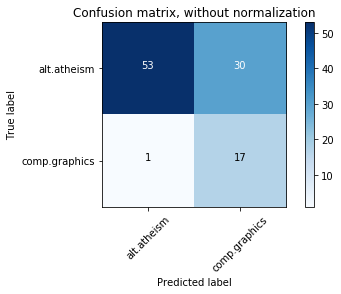

In [19]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_Matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

### Conclusion

The total accuracy achieved is around 70% after evaluating on 2 categories from the news dataset. However, this performance can be increased if pre-processing can be further improved as some data contains lot of irrelevant information due to which algorithm fails to achieve optimal solution. 

This performance varies based on the initialization of K-means algorithm